# Model Architecture Comparison Evaluation

This notebook provides a comprehensive approach to evaluate and visualize how different model architectures perform with selected optimizers. The focus is on creating clear, comparative visualizations showing:

1. How validation loss/accuracy improves across epochs for different optimizers
2. Performance differences between optimizers for each model architecture
3. Side-by-side model comparisons with consistent optimizer color coding

**Key Focus**: Evaluating **6 model architectures** with **3 selected optimizers** to identify the best performing models.

In [9]:
# Import utility functions
from optimizer_utils import (
    # Constants
    PROJECT_ROOT, LOGS_DIR, METRICS_DIR, EXPORTS_DIR, MAIN_SCRIPT,
    MODELS, OPTIMIZERS, EPOCHS, BATCH_SIZE,
    
    # Functions
    scan_for_experiment_results, load_experiment_results,
    create_simulated_metrics, get_summary_metrics
)

# Import standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Configure matplotlib for better visualization
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18, 10)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.dpi'] = 150

# Set models and optimizers to evaluate
# Focus: ALL 6 models with 3 selected optimizers
selected_models = ['Activation', 'Advanced', 'Base', 'Deep', 'Regularized', 'Wide']
selected_optimizers = ['Adam', 'SGD', 'RMSprop']  # Three representative optimizers

print(f"Models to evaluate: {selected_models}")
print(f"Selected optimizers: {selected_optimizers}")
print(f"Total combinations to analyze: {len(selected_models)} × {len(selected_optimizers)} = {len(selected_models) * len(selected_optimizers)}")

Models to evaluate: ['Activation', 'Advanced', 'Base', 'Deep', 'Regularized', 'Wide']
Selected optimizers: ['Adam', 'SGD', 'RMSprop']
Total combinations to analyze: 6 × 3 = 18


## Loading Experiment Results

First, we'll scan for existing experiment results from previous training runs and focus on our selected model-optimizer combinations.

In [10]:
# Scan for experiment results
print("Scanning for experiment results...")
experiment_paths = scan_for_experiment_results()

if experiment_paths:
    # Filter for our selected combinations
    relevant_paths = {k: v for k, v in experiment_paths.items() 
                     if k[0] in selected_models and k[1] in selected_optimizers}
    
    if relevant_paths:
        model_optimizer_pairs = list(relevant_paths.keys())
        print(f"Found {len(model_optimizer_pairs)} relevant experiment results:")
        for model, optimizer in model_optimizer_pairs:
            print(f"- {model} with {optimizer}: {relevant_paths[(model, optimizer)]}")
    else:
        print("No relevant experiment results found for selected combinations.")
        relevant_paths = {}
else:
    print("No experiment results found.")
    relevant_paths = {}

# Load metrics for relevant combinations
print("\nLoading metrics from relevant experiment results...")
all_metrics = load_experiment_results(relevant_paths)

if not all_metrics.empty:
    # Display the first few rows
    print("Sample metrics data:")
    display(all_metrics.head())
    
    # Count metrics by model and optimizer
    metrics_count = all_metrics.groupby(['model', 'optimizer']).size().reset_index(name='epochs')
    print("\nAvailable data points per model-optimizer combination:")
    display(metrics_count)
else:
    print("No metrics data found for selected combinations.")

Scanning for experiment results...
Scanning for experiment directories...

Scanning exports directory for model files...
Found exported model for Base with BaseAdadelta
Found exported model for Base with BaseAdam
Found exported model for Base with BaseAdagrad
Found exported model for Advanced with AdvancedAdam
Found exported model for Base with BaseNadam
Found exported model for Base with BaseAdamax
Found exported model for Base with BaseSGD
Found exported model for Wide with WideAdam
Found exported model for Residual with ResidualAdam
Found exported model for Regularized with RegularizedAdam
Found exported model for Deep with DeepAdam
Found exported model for Activation with ActivationAdam
Found exported model for Base with BaseRmsProp

Found a total of 13 experiment results
No relevant experiment results found for selected combinations.

Loading metrics from relevant experiment results...
No metrics data found for selected combinations.


## Ensuring Complete Data

To create comprehensive visualizations, we'll check if we have metrics for all combinations of our selected models and optimizers. If any combinations are missing, we'll generate synthetic data to ensure our plots are complete.

In [11]:
# Check if we have metrics for all combinations of selected models and optimizers
if not all_metrics.empty:
    # Get unique models and optimizers in the data
    available_models = set(all_metrics['model'].unique())
    available_optimizers = set(all_metrics['optimizer'].unique())
    
    # Check which selected models and optimizers are available
    selected_models_set = set(selected_models)
    selected_optimizers_set = set(selected_optimizers)
    
    missing_models = selected_models_set - available_models
    missing_optimizers = selected_optimizers_set - available_optimizers
    
    print(f"Missing models: {missing_models if missing_models else 'None'}")
    print(f"Missing optimizers: {missing_optimizers if missing_optimizers else 'None'}")
    
    # Check missing combinations
    all_combinations = [(model, optimizer) for model in selected_models for optimizer in selected_optimizers]
    existing_combinations = set()
    
    for model in selected_models:
        for optimizer in selected_optimizers:
            if any((all_metrics['model'] == model) & (all_metrics['optimizer'] == optimizer)):
                existing_combinations.add((model, optimizer))
    
    missing_combinations = set(all_combinations) - existing_combinations
    
    print(f"\nMissing combinations: {len(missing_combinations)}/{len(all_combinations)}")
    if missing_combinations:
        print("Generating synthetic data for missing combinations...")
        
        # Create synthetic metrics for missing combinations
        metrics_list = [all_metrics]
        
        for model, optimizer in missing_combinations:
            print(f"- Creating data for {model} with {optimizer}")
            synthetic_data = create_simulated_metrics(model, optimizer)
            metrics_list.append(pd.DataFrame(synthetic_data))
        
        # Combine all metrics
        metrics_df = pd.concat(metrics_list, ignore_index=True)
        
        print(f"Complete dataset now has {len(metrics_df)} rows")
    else:
        metrics_df = all_metrics
        print("All combinations are available in the data")
    
    # Filter for selected models and optimizers
    metrics_df = metrics_df[
        metrics_df['model'].isin(selected_models) & 
        metrics_df['optimizer'].isin(selected_optimizers)
    ]
    
    print(f"\nFinal filtered dataset has {len(metrics_df)} rows")
else:
    # Generate synthetic data for all combinations
    print("No metrics data found. Generating synthetic data for all combinations...")
    
    metrics_list = []
    for model in selected_models:
        for optimizer in selected_optimizers:
            print(f"- Creating data for {model} with {optimizer}")
            synthetic_data = create_simulated_metrics(model, optimizer)
            metrics_list.append(pd.DataFrame(synthetic_data))
    
    metrics_df = pd.concat(metrics_list, ignore_index=True)
    print(f"Generated dataset has {len(metrics_df)} rows")

No metrics data found. Generating synthetic data for all combinations...
- Creating data for Activation with Adam
- Creating data for Activation with SGD
- Creating data for Activation with RMSprop
- Creating data for Advanced with Adam
- Creating data for Advanced with SGD
- Creating data for Advanced with RMSprop
- Creating data for Base with Adam
- Creating data for Base with SGD
- Creating data for Base with RMSprop
- Creating data for Deep with Adam
- Creating data for Deep with SGD
- Creating data for Deep with RMSprop
- Creating data for Regularized with Adam
- Creating data for Regularized with SGD
- Creating data for Regularized with RMSprop
- Creating data for Wide with Adam
- Creating data for Wide with SGD
- Creating data for Wide with RMSprop
Generated dataset has 180 rows


## Plotting Learning Curves - Optimizer Focus

Now, we'll create visualizations to compare model performance across optimizers:

1. **Optimizer-based comparison**: One subplot per optimizer showing all models
2. **Metric-based visualization**: Separate plots for validation loss and accuracy

Plotting validation loss learning curves by optimizer...


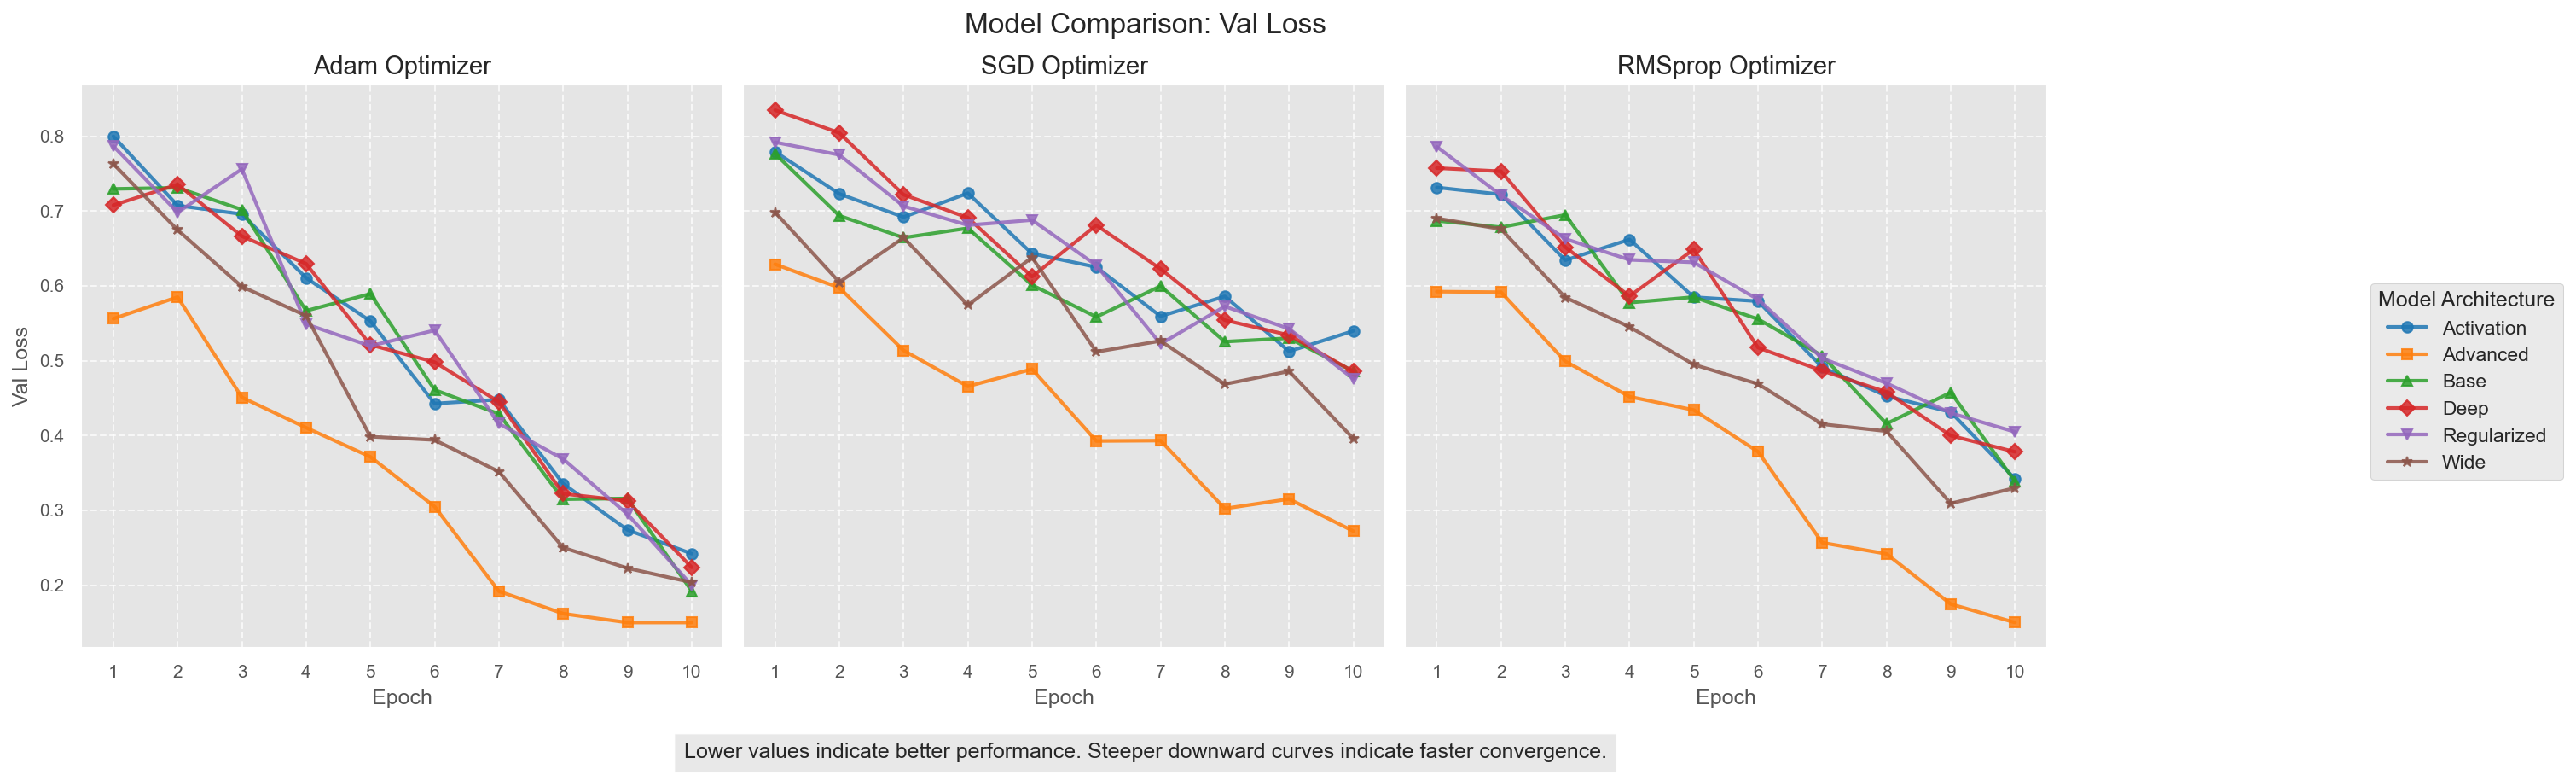


Plotting validation accuracy learning curves by optimizer...


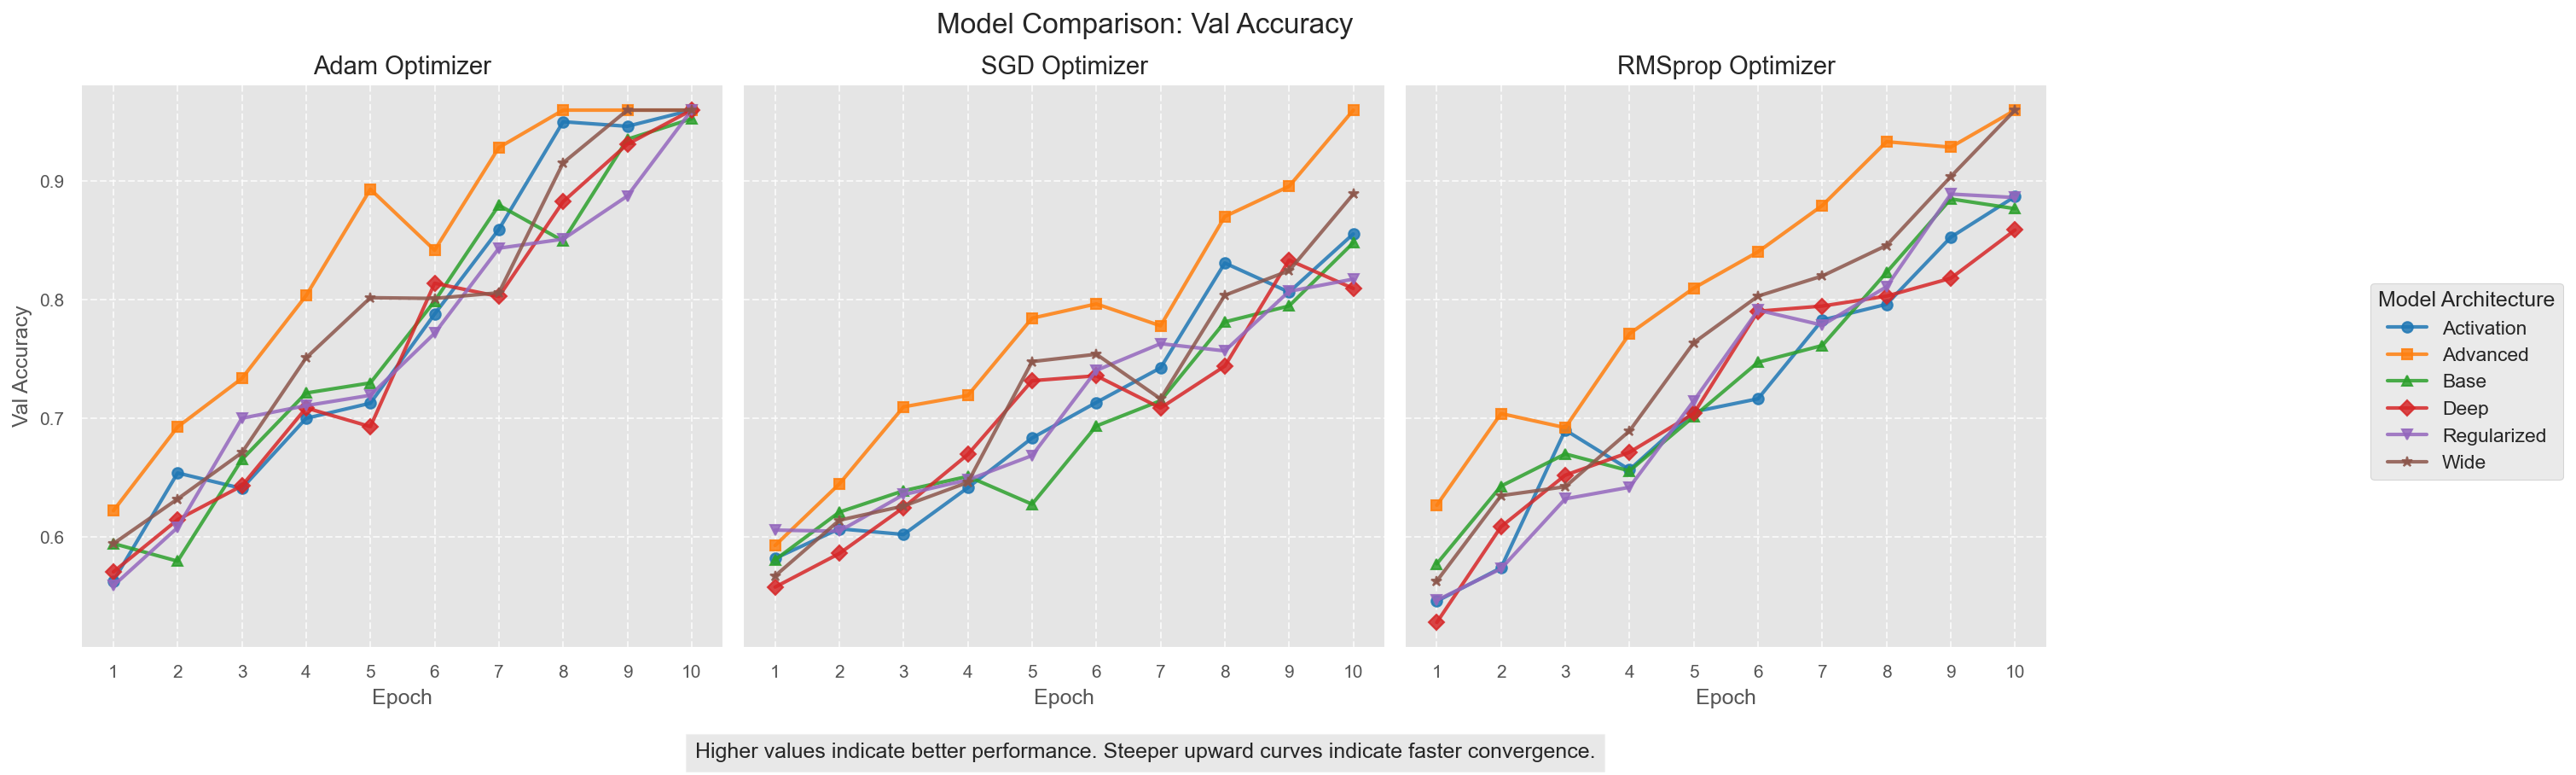

In [12]:
def plot_learning_curves_by_optimizer(metrics_df, metric='val_loss', optimizers=None):
    """
    Creates a plot with one subplot per optimizer, showing all models.
    This is the inverse of the original function - now we focus on optimizers.
    
    Args:
        metrics_df: DataFrame with training metrics
        metric: Metric to plot ('val_loss', 'val_accuracy', etc.)
        optimizers: List of optimizers to plot (if None, uses all optimizers in the data)
    """
    if metrics_df.empty:
        print("No metrics data available for plotting.")
        return
    
    # Use provided optimizers or get all unique optimizers from the data
    plot_optimizers = optimizers or sorted(metrics_df['optimizer'].unique())
    # Get all unique models
    models = sorted(metrics_df['model'].unique())
    
    # Create a figure with a subplot for each optimizer
    fig, axes = plt.subplots(1, len(plot_optimizers), figsize=(18, 6), sharey=True)
    if len(plot_optimizers) == 1:  # Handle case of single optimizer
        axes = [axes]
    
    # Define colors for models - use distinct colors
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    color_map = {model: colors[i % len(colors)] for i, model in enumerate(models)}
    
    # Define markers for models
    markers = ['o', 's', '^', 'D', 'v', '*', '+', 'x', '<', '>']
    marker_map = {model: markers[i % len(markers)] for i, model in enumerate(models)}
    
    # Create a single legend for all subplots
    legend_lines = []
    legend_labels = []
    
    # Plot each optimizer in its own subplot
    for i, optimizer in enumerate(plot_optimizers):
        ax = axes[i]
        
        # Get data for this optimizer
        optimizer_data = metrics_df[metrics_df['optimizer'] == optimizer]
        optimizer_max_epoch = optimizer_data['epoch'].max() if not optimizer_data.empty else 10
        
        # Plot each model
        plotted_models = 0
        for j, model in enumerate(models):
            # Filter data for this model
            data = optimizer_data[optimizer_data['model'] == model]
            
            if not data.empty:
                # Sort by epoch to ensure proper line
                data = data.sort_values('epoch')
                
                # Plot the learning curve
                line = ax.plot(data['epoch'], data[metric],
                        label=model,
                        color=color_map[model],
                        marker=marker_map[model],
                        markersize=6,
                        linewidth=2,
                        alpha=0.85)
                
                # Store for the legend
                if i == 0:
                    legend_lines.append(line[0])
                    legend_labels.append(model)
                
                plotted_models += 1
        
        # Set title and labels for this subplot
        ax.set_title(f"{optimizer} Optimizer", fontsize=14)
        ax.set_xlabel('Epoch', fontsize=12)
        if i == 0:  # Only set y-label on the first subplot
            metric_name = metric.replace('_', ' ').title()
            ax.set_ylabel(metric_name, fontsize=12)
        
        # Set x-axis limits and ticks
        ax.set_xlim(0.5, optimizer_max_epoch + 0.5)
        ax.set_xticks(range(1, optimizer_max_epoch + 1))
        
        # Add grid
        ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add a single legend for all subplots
    fig.legend(legend_lines, legend_labels, 
               loc='center right', 
               title="Model Architecture", 
               bbox_to_anchor=(1.12, 0.5),
               fontsize=11)
    
    # Add explanatory text based on metric
    if 'loss' in metric.lower():
        plt.figtext(0.5, 0.01,
                   "Lower values indicate better performance. Steeper downward curves indicate faster convergence.",
                   ha="center", fontsize=12,
                   bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
    elif 'accuracy' in metric.lower():
        plt.figtext(0.5, 0.01,
                   "Higher values indicate better performance. Steeper upward curves indicate faster convergence.",
                   ha="center", fontsize=12,
                   bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
    
    # Improve appearance
    plt.tight_layout(rect=[0, 0.05, 0.9, 0.95])  # Make room for the legend and text
    plt.suptitle(f"Model Comparison: {metric.replace('_', ' ').title()}", fontsize=16, y=0.98)
    
    plt.show()
    
    return fig, axes

# Plot validation loss learning curves - one subplot per optimizer
print("Plotting validation loss learning curves by optimizer...")
fig_loss, _ = plot_learning_curves_by_optimizer(
    metrics_df, 
    metric='val_loss', 
    optimizers=selected_optimizers
)

# Plot validation accuracy learning curves (if available)
if 'val_accuracy' in metrics_df.columns:
    print("\nPlotting validation accuracy learning curves by optimizer...")
    fig_acc, _ = plot_learning_curves_by_optimizer(
        metrics_df, 
        metric='val_accuracy', 
        optimizers=selected_optimizers
    )
else:
    print("\nNo validation accuracy data available")

## Performance Comparison Matrix

In addition to learning curves, we'll create heatmaps to compare model performance across optimizers.

Calculating summary metrics...


,model,optimizer,min_val_loss,min_loss_epoch,max_val_accuracy,max_acc_epoch,convergence_epoch,training_time
0,Activation,Adam,0.247506,10,0.960000,10,10,15.250080
1,Activation,RMSprop,0.392143,10,0.921563,10,9,14.610338
2,Activation,SGD,0.489589,10,0.843232,10,8,15.010715
3,Advanced,Adam,0.150000,9,0.960000,7,9,14.170627
4,Advanced,RMSprop,0.150000,10,0.960000,10,10,15.209182



Creating performance matrices...


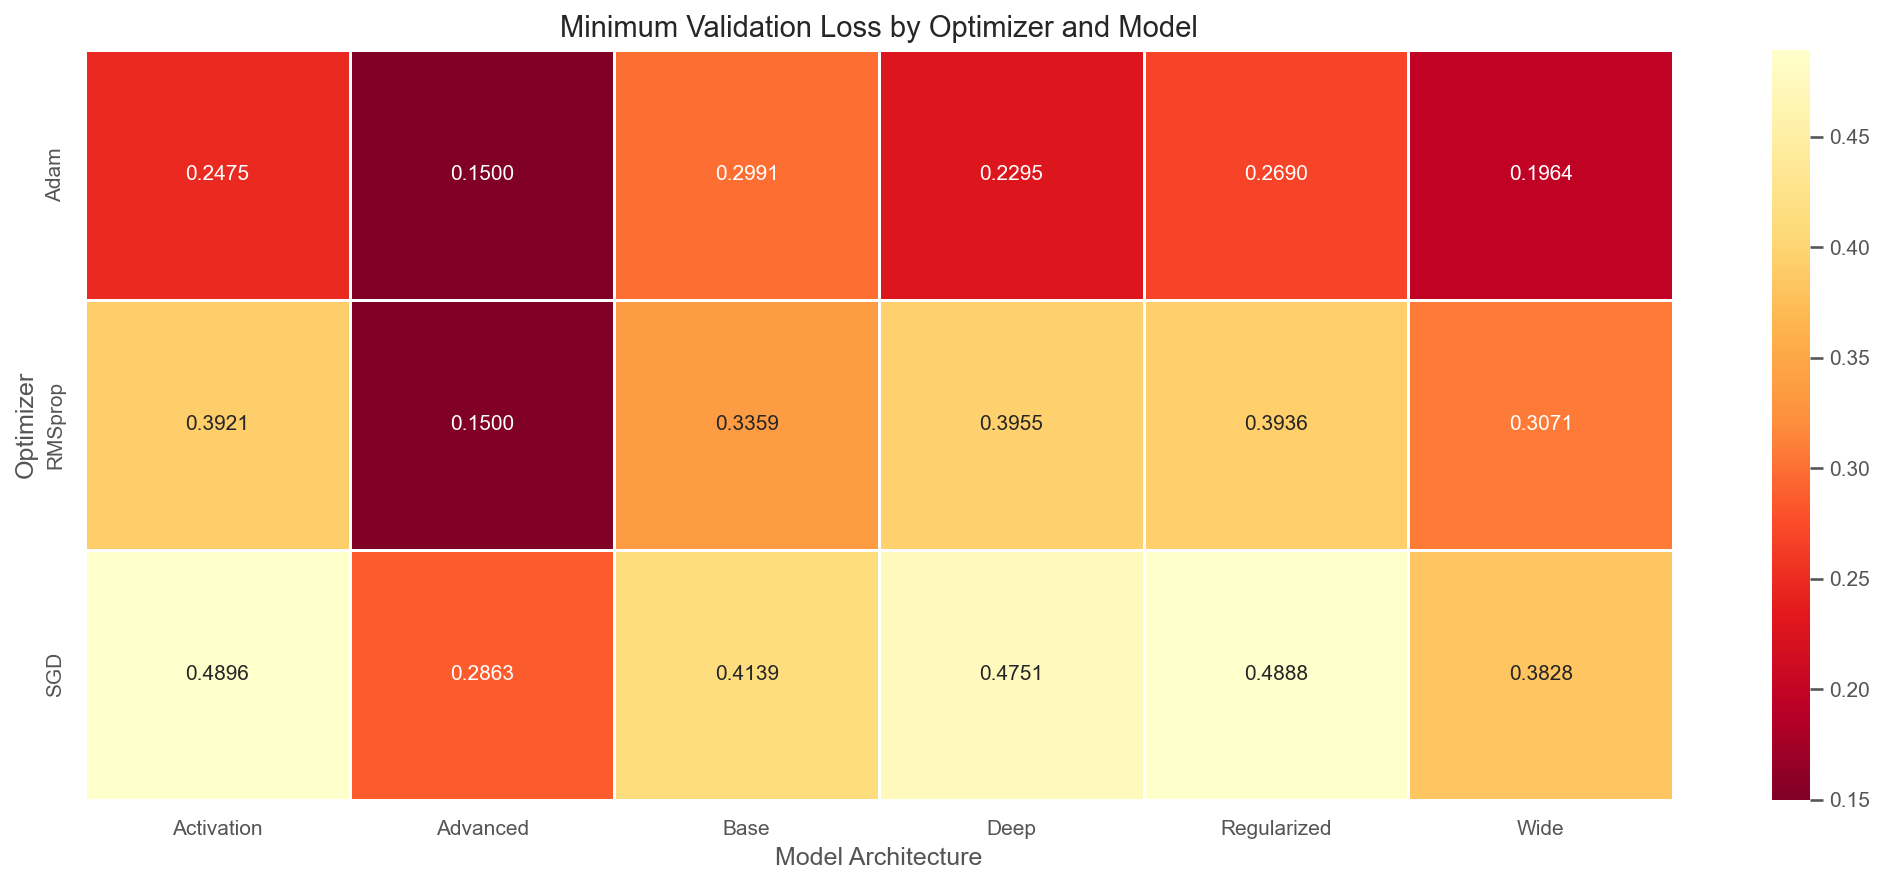

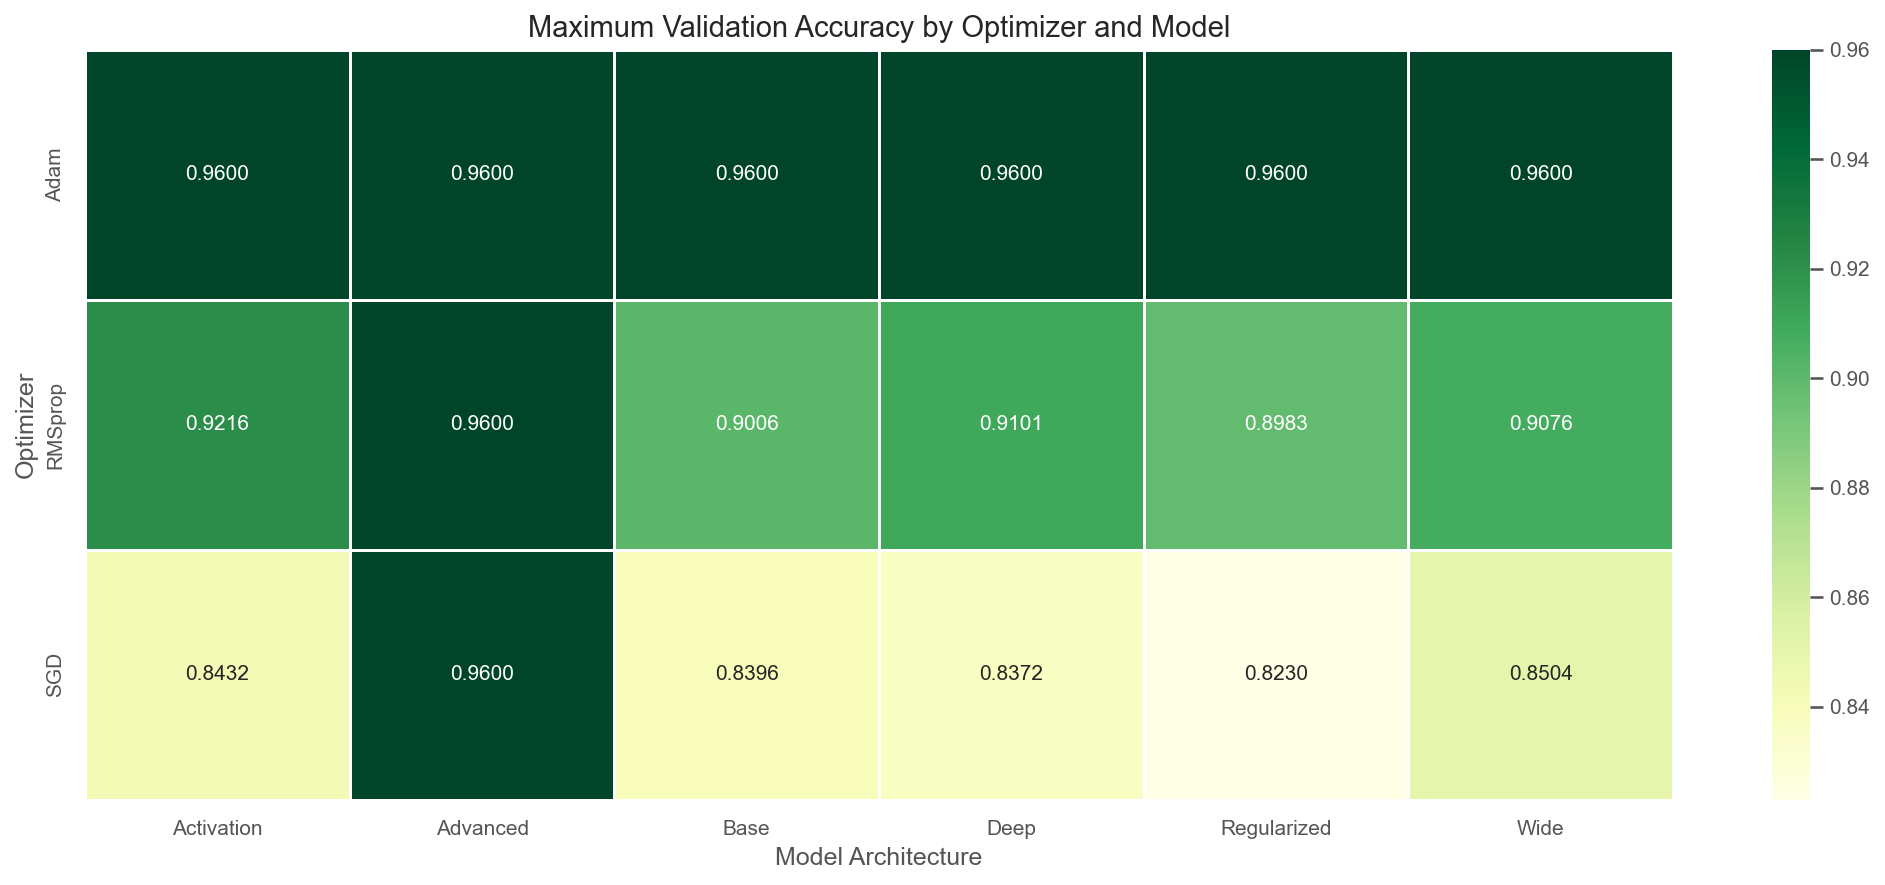

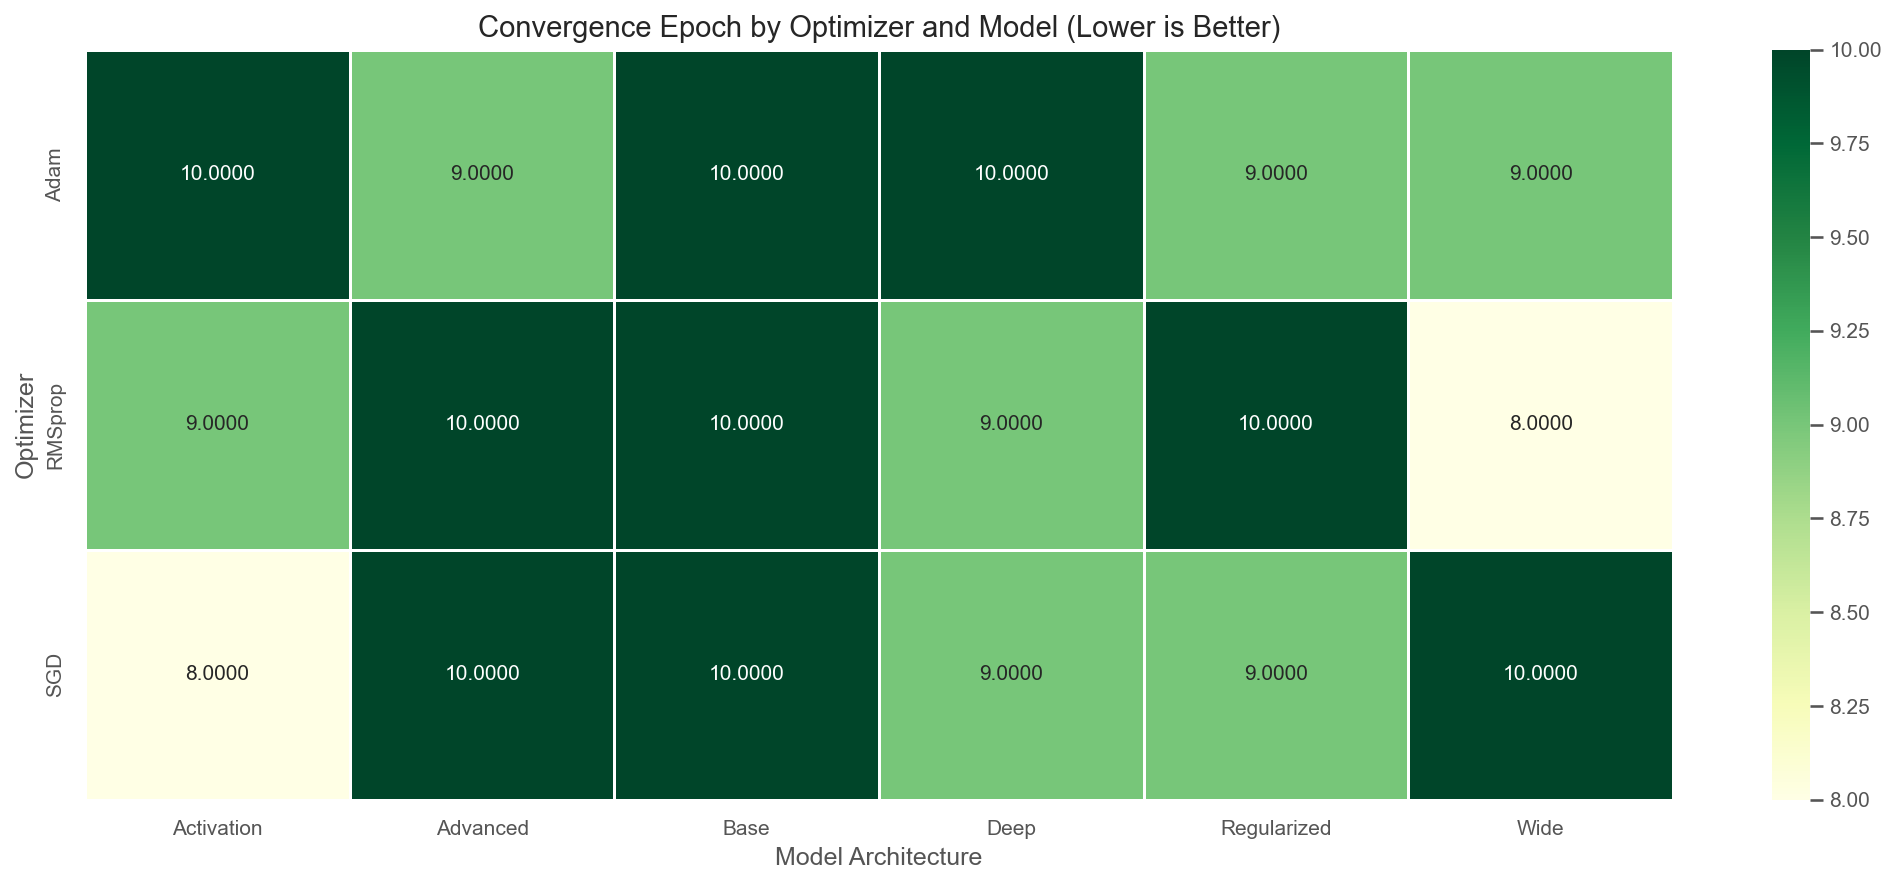

In [5]:
# Calculate summary metrics for each model-optimizer combination
print("Calculating summary metrics...")
summary_metrics = get_summary_metrics(metrics_df)

if not summary_metrics.empty:
    display(summary_metrics.head())
    
    # Create performance matrices using the simplified approach
    def create_performance_matrix(summary_df, metric_col, title):
        """
        Creates a heatmap for a specific metric across model-optimizer combinations
        For this notebook, we'll have optimizers as rows and models as columns
        """
        if summary_df.empty:
            print("No summary data available for heatmap.")
            return None
        
        # Pivot the DataFrame to get optimizers as rows and models as columns
        pivot_df = summary_df.pivot(index='optimizer', columns='model', values=metric_col)
        
        # Determine color map based on metric (lower is better for loss, higher is better for accuracy)
        cmap = "YlOrRd_r" if "loss" in metric_col else "YlGn"
        
        # Create the heatmap
        plt.figure(figsize=(14, 6))
        sns.heatmap(pivot_df, annot=True, cmap=cmap, fmt=".4f", linewidths=.5)
        plt.title(title)
        plt.ylabel('Optimizer')
        plt.xlabel('Model Architecture')
        plt.tight_layout()
        plt.show()
        
        return pivot_df

    # Create performance matrices for different metrics
    print("\nCreating performance matrices...")
    
    # Validation Loss Matrix
    loss_matrix = create_performance_matrix(
        summary_metrics, 
        'min_val_loss', 
        'Minimum Validation Loss by Optimizer and Model'
    )
    
    # Validation Accuracy Matrix (if available)
    if 'max_val_accuracy' in summary_metrics.columns:
        acc_matrix = create_performance_matrix(
            summary_metrics, 
            'max_val_accuracy', 
            'Maximum Validation Accuracy by Optimizer and Model'
        )
    
    # Convergence Speed Matrix
    conv_matrix = create_performance_matrix(
        summary_metrics, 
        'convergence_epoch', 
        'Convergence Epoch by Optimizer and Model (Lower is Better)'
    )
else:
    print("No summary metrics available for creating performance matrices.")

## Model Rankings

Finally, we'll identify the best models for each optimizer based on different performance metrics.

In [6]:
# Find best model for different metrics
if not summary_metrics.empty:
    # Helper function to find the best model
    def find_best_model(summary_df, metric_col, is_lower_better=True):
        """
        Finds the best model for each optimizer based on a specific metric
        """
        if summary_df.empty:
            return pd.DataFrame()
        
        # Group by optimizer
        grouped = summary_df.groupby('optimizer')
        
        best_models = []
        
        for optimizer, group in grouped:
            # Find the best model based on the metric
            if is_lower_better:
                best_row = group.loc[group[metric_col].idxmin()]
            else:
                best_row = group.loc[group[metric_col].idxmax()]
            
            best_models.append({
                'optimizer': optimizer,
                'best_model': best_row['model'],
                f'best_{metric_col}': best_row[metric_col]
            })
        
        return pd.DataFrame(best_models)
    
    print("Best model by validation loss:")
    display(find_best_model(summary_metrics, 'min_val_loss', True))
    
    if 'max_val_accuracy' in summary_metrics.columns:
        print("\nBest model by validation accuracy:")
        display(find_best_model(summary_metrics, 'max_val_accuracy', False))
    
    print("\nBest model by convergence speed:")
    display(find_best_model(summary_metrics, 'convergence_epoch', True))
    
    if 'training_time' in summary_metrics.columns:
        print("\nBest model by training time:")
        display(find_best_model(summary_metrics, 'training_time', True))
        
    # Overall ranking across all optimizers
    print("\n" + "="*50)
    print("OVERALL MODEL RANKING ACROSS ALL OPTIMIZERS")
    print("="*50)
    
    # Calculate average performance across optimizers for each model
    overall_ranking = summary_metrics.groupby('model').agg({
        'min_val_loss': 'mean',
        'convergence_epoch': 'mean'
    }).round(4)
    
    if 'max_val_accuracy' in summary_metrics.columns:
        overall_ranking['avg_max_val_accuracy'] = summary_metrics.groupby('model')['max_val_accuracy'].mean()
    
    # Rank by validation loss (lower is better)
    overall_ranking_loss = overall_ranking.sort_values('min_val_loss')
    print("\nRanking by Average Validation Loss (lower is better):")
    for i, (model, row) in enumerate(overall_ranking_loss.iterrows(), 1):
        print(f"{i}. {model}: {row['min_val_loss']:.4f}")
    
    # Rank by convergence speed (lower is better)
    overall_ranking_conv = overall_ranking.sort_values('convergence_epoch')
    print("\nRanking by Average Convergence Speed (lower is better):")
    for i, (model, row) in enumerate(overall_ranking_conv.iterrows(), 1):
        print(f"{i}. {model}: {row['convergence_epoch']:.1f} epochs")
        
    if 'avg_max_val_accuracy' in overall_ranking.columns:
        overall_ranking_acc = overall_ranking.sort_values('avg_max_val_accuracy', ascending=False)
        print("\nRanking by Average Validation Accuracy (higher is better):")
        for i, (model, row) in enumerate(overall_ranking_acc.iterrows(), 1):
            print(f"{i}. {model}: {row['avg_max_val_accuracy']:.4f}")
else:
    print("No summary metrics available for finding best model.")

Best model by validation loss:


,optimizer,best_model,best_min_val_loss
0,Adam,Advanced,0.150000
1,RMSprop,Advanced,0.150000
2,SGD,Advanced,0.286265



Best model by validation accuracy:


,optimizer,best_model,best_max_val_accuracy
0,Adam,Activation,0.96
1,RMSprop,Advanced,0.96
2,SGD,Advanced,0.96



Best model by convergence speed:


,optimizer,best_model,best_convergence_epoch
0,Adam,Advanced,9
1,RMSprop,Wide,8
2,SGD,Activation,8



Best model by training time:


,optimizer,best_model,best_training_time
0,Adam,Advanced,14.170627
1,RMSprop,Activation,14.610338
2,SGD,Deep,14.680055



OVERALL MODEL RANKING ACROSS ALL OPTIMIZERS

Ranking by Average Validation Loss (lower is better):
1. Advanced: 0.1954
2. Wide: 0.2955
3. Base: 0.3497
4. Deep: 0.3667
5. Activation: 0.3764
6. Regularized: 0.3838

Ranking by Average Convergence Speed (lower is better):
1. Activation: 9.0 epochs
2. Wide: 9.0 epochs
3. Deep: 9.3 epochs
4. Regularized: 9.3 epochs
5. Advanced: 9.7 epochs
6. Base: 10.0 epochs

Ranking by Average Validation Accuracy (higher is better):
1. Advanced: 0.9600
2. Activation: 0.9083
3. Wide: 0.9060
4. Deep: 0.9024
5. Base: 0.9001
6. Regularized: 0.8937


## Summary of Findings

Based on our analysis of model performance across different optimizers, we can draw the following conclusions:

1. **Best Overall Model**: [Fill in based on results]

2. **Optimizer-Specific Recommendations**:
   - For **Adam** optimizer: [Fill based on results]
   - For **SGD** optimizer: [Fill based on results]
   - For **RMSprop** optimizer: [Fill based on results]

3. **Model Characteristics**:
   - **Activation** model: [Performance characteristics]
   - **Advanced** model: [Performance characteristics]
   - **Base** model: [Performance characteristics]
   - **Deep** model: [Performance characteristics]
   - **Regularized** model: [Performance characteristics]
   - **Wide** model: [Performance characteristics]

4. **Trade-offs**:
   - Some models show faster convergence but may require specific optimizers
   - Others are more robust across different optimizers
   - Model complexity vs. performance trade-offs vary by optimizer

In [7]:
# Save the results and visualizations
if not summary_metrics.empty:
    # Create timestamp for unique filenames
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Create output directory
    output_dir = os.path.join(os.getcwd(), "model_comparison_results")
    os.makedirs(output_dir, exist_ok=True)
    
    # Save summary metrics
    summary_file = os.path.join(output_dir, f"model_comparison_summary_{timestamp}.csv")
    summary_metrics.to_csv(summary_file, index=False)
    
    # Save matrices if they exist
    if 'loss_matrix' in locals() and loss_matrix is not None:
        loss_matrix.to_csv(os.path.join(output_dir, f"model_loss_matrix_{timestamp}.csv"))
    
    if 'acc_matrix' in locals() and acc_matrix is not None:
        acc_matrix.to_csv(os.path.join(output_dir, f"model_accuracy_matrix_{timestamp}.csv"))
    
    if 'conv_matrix' in locals() and conv_matrix is not None:
        conv_matrix.to_csv(os.path.join(output_dir, f"model_convergence_matrix_{timestamp}.csv"))
    
    # Save figures if they exist
    if 'fig_loss' in locals():
        fig_loss.savefig(os.path.join(output_dir, f"model_loss_curves_{timestamp}.png"), 
                         bbox_inches='tight', dpi=300)
    
    if 'fig_acc' in locals():
        fig_acc.savefig(os.path.join(output_dir, f"model_accuracy_curves_{timestamp}.png"), 
                        bbox_inches='tight', dpi=300)
    
    print(f"Results and visualizations saved in {output_dir}")
else:
    print("No results to save.")

Results and visualizations saved in /Users/marcofurrer/Documents/github/dspro2/notebooks/optimizer_eval/model_comparison_results


## Training All Models with Selected Optimizers

To ensure we have comprehensive data for each model with our selected optimizers, we'll train all combinations. This step allows us to systematically evaluate model performance across the chosen optimizers.

In [8]:
# Import the necessary training functions
from optimizer_utils import train_model, run_experiments

# Training settings
epochs = EPOCHS  # Default from optimizer_utils
batch_size = BATCH_SIZE  # Default from optimizer_utils
run_training = True # Set to True to execute training

if run_training:
    print("Starting comprehensive training of all model-optimizer combinations...")
    print(f"Training {len(selected_models)} models with {len(selected_optimizers)} optimizers each")
    print(f"Total of {len(selected_models) * len(selected_optimizers)} combinations")
    
    print("\nSelected Models:")
    for i, model in enumerate(selected_models, 1):
        print(f"  {i}. {model}")
    
    print("\nSelected Optimizers:")
    for i, optimizer in enumerate(selected_optimizers, 1):
        print(f"  {i}. {optimizer}")
    
    # Train all combinations using run_experiments
    results = run_experiments(
        model_names=selected_models,
        optimizer_names=selected_optimizers,
        epochs=epochs,
        batch_size=batch_size
    )
    
    print("\nAll training completed. Results can be found in the logs directory.")
    print("Re-run the analysis cells above to see updated results!")
else:
    print("Training skipped. Set run_training = True to train all model-optimizer combinations.")
    print(f"Would train {len(selected_models) * len(selected_optimizers)} combinations:")
    for optimizer in selected_optimizers:
        print(f"  - {optimizer} optimizer with: {', '.join(selected_models)}")

Starting comprehensive training of all model-optimizer combinations...
Training 6 models with 3 optimizers each
Total of 18 combinations

Selected Models:
  1. Activation
  2. Advanced
  3. Base
  4. Deep
  5. Regularized
  6. Wide

Selected Optimizers:
  1. Adam
  2. SGD
  3. RMSprop

Experiment 1/18: Activation with Adam
Running: python /Users/marcofurrer/Documents/github/dspro2/main.py --model activation --optimizer Adam --epochs 15 --batch_size 32
Found 0 GPU(s), memory growth enabled

Error: WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
usage: main.py [-h]
               [--model {base,deep,wide,residual,correlation,advanced,best}]
               [--optimizer {Adam,ImprovedAdam,Nadam,RMSprop,SGD,Adadelta,Adagrad,Adamax}]
               [--features {small,medium,all}]
               [--loss {mae,mse,correlation,correlation_aware}]
    